In [1]:
!pip install -r /content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/requirements.txt

     |████████████████████████████████| 2.1 MB 7.6 MB/s 
  Created wheel for dcase-util: filename=dcase_util-0.2.18-py3-none-any.whl size=2147231 sha256=1ce26f0bec1099fbcef7abab8a5a8de0224dd37c5acda67100022e65047de0ec
  Stored in directory: /root/.cache/pip/wheels/f2/75/d1/e4fc6f415d1100dc30c39c955aa2bfbd0d88c6138076e74793
  Created wheel for sed-eval: filename=sed_eval-0.2.1-py3-none-any.whl size=26124 sha256=ea88655946e6673a82bf9aaec96d77c16abfeba73684d614a9a35c55c3df174d
  Stored in directory: /root/.cache/pip/wheels/96/19/00/a3ec89acfdbd2568185a1ae3020590e76ee73a47ac4ff83e84
Successfully built dcase-util sed-eval


In [2]:
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [3]:
import numpy as np
import os
import librosa
import librosa.display

In [4]:
! pip install dcase_util
import dcase_util

In [6]:
import dcase_util
from dcase_util.containers import AudioContainer
import os, numpy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sed_eval
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = '/content/data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_sed')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

# Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_sed.h5')  

# def get_feature_filename(audio_filename, feature_storage_path):
#     """Get feature filename from audio filename. """
    
#     return dcase_util.utils.Path(path=audio_filename).modify(
#         path_base=feature_storage_path, 
#         filename_extension='.npy'
#     )
    
# def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features_sed')):  
#     """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
#     feature_filename = get_feature_filename(audio_filename, feature_storage_path)
#     if os.path.exists(feature_filename):
#         return numpy.load(feature_filename)
#     else:
#         audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
#         mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs)
#         mel_data = mel_extractor.extract(y=audio)
#         numpy.save(feature_filename, mel_data)
#         return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.keras.setup_keras(backend='tensorflow')
import keras
from keras.layers import *
from keras.models import Model

In [7]:
def readAudio(filename):
    x, sr = librosa.load(filename, sr=16000)
    return x, sr

#calculate spectrogram
def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex256))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

In [8]:
import librosa
def get_feature_matrix(audio_filename_path):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    audio, fs = librosa.load(audio_filename_path)
    hop_len = 0.02
    mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=hop_len, fs = fs)
    mel_data = mel_extractor.extract(y=audio)
    #numpy.save(feature_filename, mel_data)
    return mel_data, hop_len
        

In [9]:
import librosa
def get_feature_matrix_script_features(audio_filename_path):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    audio, fs = librosa.load(audio_filename_path, sr = 16000)
    mel_data = calc_spec(audio)
    # hop_len = 0.02
    # mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=hop_len, fs = fs)
    # mel_data = mel_extractor.extract(y=audio)
    #numpy.save(feature_filename, mel_data)

    return mel_data, 10/mel_data.shape[1]
        

In [10]:
# print(get_feature_matrix_script_features('/content/S001.wav')[1], get_feature_matrix('/content/S001.wav')[1])

In [11]:
def csv_to_meta_container(csv_file_path):
  dict_container = dcase_util.containers.ListDictContainer(filename = csv_file_path)
  dict_container.load()
  train_meta = dcase_util.containers.MetaDataContainer(dict_container)
  print(train_meta)
  return train_meta

In [12]:
train_meta = csv_to_meta_container('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/train.csv')

MetaDataContainer :: Class
Items                               : 1805 
Unique
  Files                             : 855 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S1                       0.00     5.00   -                 music             -                 -       
  S1                       5.00    10.00   -                 speech            -                 -       
  S2                       0.00     5.00   -                 music             -                 -       
  S2                       5.00    10.00   -                 speech            -                 -       
  S3                  

In [13]:
X_train = []
Y_train = []
audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/train'
for audio_filename in os.listdir(audio_folder_name):#os.listdir() s1.wav, s2.wav
    #print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    #features = features#features[:,:450] 
    #feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = train_meta.filter(filename=audio_filename.split('.')[0])
    event_roll = event_list.to_event_roll(
        label_list = ['speech', 'music'],                                       # Event labels
        time_resolution = hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds = features.shape[1] * hop_length_seconds   # Length of original audio signal
    ).data
    #target_matrix = data_sequencer.sequence(event_roll)
    
    # print(features.shape, event_roll.shape)
    # print(type(features), type(np.array(event_roll.data)))
    X_train.append(features) 
    Y_train.append(np.array(event_roll))

print(len(Y_train))  
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)
Y_train = np.moveaxis(Y_train, 1, 2)
print('----------------------')
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

850
----------------------
X_train shape (850, 513, 313)
Y_train shape (850, 313, 2)


In [14]:
# import numpy as np
# np.save('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features_new.npy', X_train)
# np.save('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/Y_train_script_features_new.npy', Y_train)

In [15]:
# import numpy as np
# np.save('/content/X_train_script_features.npy', X_train)
# np.save('/content/Y_train_script_features.npy', Y_train)

In [16]:
import numpy as np
def load_features_and_labels(features_path, labels_path):
  X = np.load(features_path)
  Y = np.load(labels_path)
  return X, Y

In [17]:
# a, b = load_features_and_labels('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features.npy', '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/Y_train_script_features.npy')

In [18]:
# print(a.shape, b.shape)

In [19]:
# X_train, Y_train = load_features_and_labels('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features.npy', '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/Y_train_script_features.npy')

In [20]:
# a = np.load('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features.npy')

In [21]:
# print(X_train.shape, Y_train.shape)

In [22]:
# ! rm -r '/content/audio_files/.ipynb_checkpoints'

In [23]:
validation_meta = csv_to_meta_container('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/validation.csv')

MetaDataContainer :: Class
Items                               : 360 
Unique
  Files                             : 170 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S26                      0.00     5.00   -                 music             -                 -       
  S26                      5.00    10.00   -                 speech            -                 -       
  S27                      0.00     5.00   -                 music             -                 -       
  S27                      5.00    10.00   -                 speech            -                 -       
  S28                  

In [24]:
X_validation = []
Y_validation = []
validation_data = {}
audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/validation'
for audio_filename in os.listdir(audio_folder_name):#os.listdir() s1.wav, s2.wav
    #print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    features = features[:,:500] 
    #feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = validation_meta.filter(filename=audio_filename.split('.')[0])
    event_roll = event_list.to_event_roll(
        label_list = ['speech', 'music'],                                       # Event labels
        time_resolution = hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds = features.shape[1] * hop_length_seconds   # Length of original audio signal
    ).data
    #target_matrix = data_sequencer.sequence(event_roll)
    
    # print(features.shape, event_roll.shape)
    # print(type(features), type(np.array(event_roll.data)))
    X_validation.append(features) 
    Y_validation.append(np.array(event_roll))

    validation_data[audio_filename] = {
        'features' : features,
        'meta' : event_list
    }
    
X_validation = np.stack(X_validation)
Y_validation = np.stack(Y_validation)
Y_validation = np.moveaxis(Y_validation, 1, 2)
print('----------------------')
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

----------------------
X_validation shape (170, 513, 313)
Y_validation shape (170, 313, 2)


In [25]:
# print(validation_data)

In [26]:
# X_validation, Y_validation = load_features_and_labels

Next we create **CRNN** styled neural network structure layer by layer


**Input** layer and **Reshaping** layer to add channel axis into input to match `channels_last` mode:

In [12]:
feature_vector_length = 513   # Number of mel bands
sequence_length = 313

In [13]:
print(feature_vector_length)

513


In [14]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)


In [15]:
print('Output shape','(sequence, frequency, time, channel)', x.shape)

Output shape (sequence, frequency, time, channel) (None, 513, 313, 1)


**Two convolutional groups** are used to capture small shifts in time and frequency. 

Similar groups as in sound classification example, except max **pooling done only along frequency** axis as time axis is retained for the detection.


In [16]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 513, 313, 1)


In [17]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear', kernel_initializer='random_normal',
           padding='same', data_format='channels_last', name='Conv1')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv1_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv1_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(5, 1), name='Conv1_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv1_DropOut')(x)


In [18]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 102, 313, 64)


In [19]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 102, 313, 64)


In [20]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear', kernel_initializer='random_normal',
           padding='same', data_format='channels_last', name='Conv2')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv2_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(4, 1), name='Conv2_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)


In [21]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 25, 313, 64)


To **connect** convolutional layers and recurrent layers, output of the last convolutional group has to be  **Reordered** and **Reshaped**:

In [22]:
print('Input shape', '(sequence, frequency, time, feature)', x.shape)

Input shape (sequence, frequency, time, feature) (None, 25, 313, 64)


In [23]:
x = Permute(
    dims=(1, 3, 2), 
    name='Permute'
)(x)

x = Reshape(
    target_shape=(sequence_length, -1), 
    name='Reshape'
)(x)


In [24]:
print('Output shape', '(sequence, time, feature)', x.shape)

Output shape (sequence, time, feature) (None, 313, 1600)


Two **bidirectional** **recurrent** layers (Gated Recurrent Units) are used to integrate information from large time window:

In [25]:
print('Input shape', '(sequence, time, feature)', x.shape)

Input shape (sequence, time, feature) (None, 313, 1600)


In [26]:
x = Bidirectional(
    SimpleRNN(
        units=32, activation='tanh', 
        dropout=0.2, recurrent_dropout=0.2, 
        return_sequences=True, kernel_initializer='random_normal'
    ), merge_mode='mul', name='Recurrent_1'
)(x)
x = Bidirectional(
    SimpleRNN(units=32, activation='tanh', 
        dropout=0.2, recurrent_dropout=0.2, 
        return_sequences=True, kernel_initializer='random_normal'
    ), merge_mode='mul', name='Recurrent_2'
)(x)

In [27]:
print('Output shape', '(sequence, time, feature)', x.shape)

Output shape (sequence, time, feature) (None, 313, 32)


**Recognition** is done with two **fully-connected** layers using information extracted by the previous layers. 

Layers are wrapped with `TimeDistributed` class to apply layers independently to each time step.

**Output layer** (last fully-connected layer) is with sigmoid activation.

In [28]:
x = TimeDistributed(
    Dense(units=32, kernel_initializer='random_normal'), name='FC1', 
)(x)
x = Dropout(rate=0.2, name='FC_DropOut')(x)
x = TimeDistributed(
    Dense(units=2, kernel_initializer='random_normal'), name='Output'
)(x)
output_layer = Activation('sigmoid', name='Output_Activation')(x)

In [29]:
print('Output shape', '(sequence, time, classes)', output_layer.shape)

Output shape (sequence, time, classes) (None, 313, 2)


Create a model network:

In [30]:
model = Model(inputs=input_layer, outputs=output_layer)

In [31]:
# del FC1

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 513, 313)]        0         
                                                                 
 Input_Reshape (Reshape)     (None, 513, 313, 1)       0         
                                                                 
 Conv1 (Conv2D)              (None, 513, 313, 64)      640       
                                                                 
 Conv1_BatchNorm (BatchNorma  (None, 513, 313, 64)     256       
 lization)                                                       
                                                                 
 Conv1_Activation (Activatio  (None, 513, 313, 64)     0         
 n)                                                              
                                                                 
 Conv1_Pooling (MaxPooling2D  (None, 102, 313, 64)     0     

## Training

One should evaluate validation data with **same metric** which is used in actual system evaluation with test set 

For sound event detection, `keras` does not provide any suitable metric (such as *segment-based error rate (ER)* or *f-score (F1)*)

Default `keras` training process needs to be modified by halting it after each epoch:
- Validation data is evaluated with current model **outside the training process**
- Metric values are stored and used to control the training process (e.g. model selection or early stopping)

## Callbacks

In [48]:
!pip install colorama

In [49]:
epochs = 100
keras_metric = 'binary_accuracy'
keras_loss = 'binary_crossentropy'
metric_to_monitor = 'ER'
external_metrics = {
    'ER': 'Error rate',
    'F1': 'F-score'
}

callback_list = [
    dcase_util.tfkeras.ProgressLoggerCallback(
        epochs=epochs,
        metric=keras_metric,
        loss=keras_loss,
        output_type='console',
        show_timing=False,
        manual_update=True,
        external_metric_labels=external_metrics        
    ),
    #dcase_util.keras.StopperCallback(
    #    epochs=epochs,
    #    monitor=metric_to_monitor,
    #    patience=10,
    #    initial_delay=50,
    #    min_delta=0,
    #    manual_update=True,
    #    external_metric_labels=external_metrics
    #),
    dcase_util.tfkeras.StasherCallback(
        epochs=epochs,
        monitor=metric_to_monitor,
        initial_delay=50,
        manual_update=True,
        external_metric_labels=external_metrics
    )
]

In [50]:
from tensorflow.keras.optimizers import Adam
model.compile(
    loss=keras_loss,
    metrics=[keras_metric],
    optimizer=Adam(lr=0.001, decay=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [51]:
# Reorder target to fit model
Y_train = numpy.moveaxis(Y_train, 1, 2)
Y_validation = numpy.moveaxis(Y_validation, 1, 2)

print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (850, 513, 313)
Y_train shape (850, 2, 313)
X_validation shape (170, 513, 313)
Y_validation shape (170, 2, 313)


In [52]:
from tensorflow.keras.callbacks import *

In [53]:
X_train = X_train[:, :, :]
Y_train = Y_train[:, :, :]

In [54]:
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (850, 513, 313)
Y_train shape (850, 2, 313)
X_validation shape (170, 513, 313)
Y_validation shape (170, 2, 313)


In [55]:
# Reorder target to fit model
Y_train = numpy.moveaxis(Y_train, 2, 1)
Y_validation = numpy.moveaxis(Y_validation, 2, 1)

print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (850, 513, 313)
Y_train shape (850, 313, 2)
X_validation shape (170, 513, 313)
Y_validation shape (170, 313, 2)


In [33]:
model = keras.models.load_model(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_birnn_sed_weights', f'model_seds_direct_script_upto_30_epochs_new.h5')) # Load model

In [ ]:
epochs = 40
# Variable to training history including metrics calculated outside keras
history_over_epochs = {
    'loss': [],
    'val_loss': [],
    'val_er': [],
    'val_f1': [],
    'binary_accuracy' : [],
    'val_binary_accuracy' : []
}

# Do training epoch by epoch
for epoch_start in range(0, 40):

    model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_birnn_sed_weights', f'model_seds_direct_script_upto_{epoch_start}_epochs_new.h5'))
    epoch_end = epoch_start + 1

    dcase_util.files.Serializer().save_cpickle(
    filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_birnn_sed_weights', f'model_cnn_rnn_sed_training_history_upto_{epoch_start}_epochs_new.cpickle'),
    data=history_over_epochs
)
    # Make sure we have only specified amount of epochs
    if epoch_end > epochs:
        epoch_end = epochs

    # Train model
    history = model.fit( x=X_train,        y=Y_train,        validation_data=(X_validation, Y_validation),
        callbacks= callback_list,
        verbose=0,
        initial_epoch=epoch_start,
        epochs=epoch_end,        batch_size=8,        shuffle=True
    )
    
    # Initialize evaluator
    evaluator = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=['speech', 'music'],
        time_resolution=1.0,
    )
    
    # Go through all validation files, do detection and accumulate intermediate statistics for metric calculation
    for audio_filename, validation_item in validation_data.items():
        # Get input features
        #input_data = data_sequencer.sequence(validation_item['features']).data
        input_data = validation_item['features']#numpy.moveaxis(validation_item['features'], 2, 0)
        input_data = np.expand_dims(input_data, 0)
        # Get per frame probabilities in sequences (3D matrix)
        item_probabilities_seq = model.predict(x=input_data)
        # Merge sequences together (2D matrix)
        item_probabilities = numpy.vstack(item_probabilities_seq)

        # Binarization 
        event_activity = dcase_util.data.ProbabilityEncoder().binarization(
            probabilities=item_probabilities,
            binarization_type='global_threshold',
            threshold=0.4
        )
        
        # Get list of detected events
        current_estimated = dcase_util.containers.MetaDataContainer()
        for event_id, event_label in enumerate(['speech', 'music']):
            # Convert active frames into segments and translate frame indices into timestamps
            event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
                activity_array=event_activity[:, event_id]
            ) * 0.03194888178

            # Form event items
            for event in event_segments:
                current_estimated.append(
                    {
                        'filename': audio_filename,
                        'onset': event[0],
                        'offset': event[1],
                        'event_label': event_label
                    }
                )
                
        # Accumulate evaluator with current file
        evaluator.evaluate(
            reference_event_list=validation_item['meta'],
            estimated_event_list=current_estimated
        )

    # Calculate metrics
    overall_metrics = evaluator.results_overall_metrics()
    er = overall_metrics['error_rate']['error_rate']
    fscore = overall_metrics['f_measure']['f_measure']

    # Inject external metric values to the callbacks
    for callback in callback_list:
        if hasattr(callback, 'set_external_metric_value'):
            callback.set_external_metric_value(
                metric_label='ER',
                metric_value=er
            )
            callback.set_external_metric_value(
                metric_label='F1',
                metric_value=fscore
            )

    # Store metrics
    history_over_epochs['loss'].append(history.history['loss'])
    history_over_epochs['val_loss'].append(history.history['val_loss'])
    history_over_epochs['val_er'].append(er)
    history_over_epochs['val_f1'].append(fscore)
    history_over_epochs['binary_accuracy'].append(history.history['binary_accuracy'])
    history_over_epochs['val_binary_accuracy'].append(history.history['val_binary_accuracy'])

    # Manually update callbacks
    for callback in callback_list:
        if hasattr(callback, 'update'):
            callback.update()

    # Check if we need to stop training
    stop_training = False
    for callback in callback_list:
        if hasattr(callback, 'stop'):
            if callback.stop():
                stop_training = True
                break

    if stop_training:
        # Stop the training loop
        break

    #model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight', f'model_seds_direct_script_upto_{epochs}_epochs.h5'))
# Manually update callbacks
for callback in callback_list:
    if hasattr(callback, 'close'):
        callback.close()


# Save model
# model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight', 'model_seds_direct_script_upto_10_epochs.h5'))

  Training
            Loss                      Metric                    Ext. metrics                                  
            binary_crossentropy       binary_accuracy                                                         
  Epoch     Train        Val          Train        Val          Error rate     F-score       
  -------   ----------   ----------   ----------   ----------   ------------   ------------  
  1         0.5752       0.5935       0.7012       0.7024       1.3880         0.4541        
  2         0.5354       0.5611       0.7004       0.6963       1.5440         0.5236        
  3         0.5058       0.5583       0.7036       0.6732       1.7960         0.5205        
  4         0.4908       0.4907       0.7087       0.7106       1.1640         0.6054        
  5         0.4785       0.5173       0.7090       0.6820       1.6470         0.5462        
  6         0.5047       0.6209       0.7094       0.5988       2.0540         0.4920        
  7         0.4

In [ ]:
# print(history.history.keys())

In [ ]:
print(history_over_epochs)

{'loss': [[0.6241568326950073], [0.5950871706008911], [0.5691238045692444]], 'val_loss': [[0.23246993124485016], [0.1910528689622879], [0.5338076949119568]], 'val_er': [0.0, 9.007199254740992e+16, 9.322451228656927e+17], 'val_f1': [nan, nan, nan], 'binary_accuracy': [[0.68879634141922], [0.6996092200279236], [0.699848473072052]], 'val_binary_accuracy': [[1.0], [0.9976038336753845], [0.7929978966712952]]}


In [ ]:
# model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_birnn_sed_weights', 'model_seds_direct_script_30_upto_40_epochs_new.h5'))

## Best performing model

Best performing model was stored during the training process in `StasherCallback`:

In [ ]:
# for callback in callback_list:
#     if isinstance(callback, dcase_util.keras.StasherCallback):                
#         model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
#         callback.show()                                         # Show information
#         break

Save model and training history:

In [ ]:
# # Save training history
# dcase_util.files.Serializer().save_cpickle(
#     filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project', 'model_cnn_rnn_sed_training_history_upto_30_epochs_new.cpickle'),
#     data=history_over_epochs
# )

## Training history

In [36]:
hist = dcase_util.files.Serializer().load_cpickle(filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_birnn_sed_weights', f'model_cnn_rnn_sed_training_history_upto_30_epochs_new.cpickle'))

In [37]:
print(hist)

{'loss': [[0.6152997612953186], [0.5752012729644775], [0.5353773832321167], [0.5057756900787354], [0.4908308982849121], [0.47849544882774353], [0.5046899318695068], [0.47679704427719116], [0.4679916501045227], [0.450372576713562], [0.44242146611213684], [0.4295198321342468], [0.41701287031173706], [0.4076094329357147], [0.4030444324016571], [0.41892534494400024], [0.39387622475624084], [0.3773784339427948], [0.3729286789894104], [0.38310226798057556], [0.35477808117866516], [0.36733874678611755], [0.368082195520401], [0.35389041900634766], [0.3447137773036957], [0.3907155394554138], [0.36317741870880127], [0.33820125460624695], [0.3360576331615448], [0.3279830813407898]], 'val_loss': [[0.6295843720436096], [0.5934728980064392], [0.5611177086830139], [0.5583460927009583], [0.4907492995262146], [0.5173248648643494], [0.6208686828613281], [0.5036896467208862], [0.5084494352340698], [0.6017616987228394], [0.5584091544151306], [0.4260995388031006], [0.7043339610099792], [0.5720074772834778]

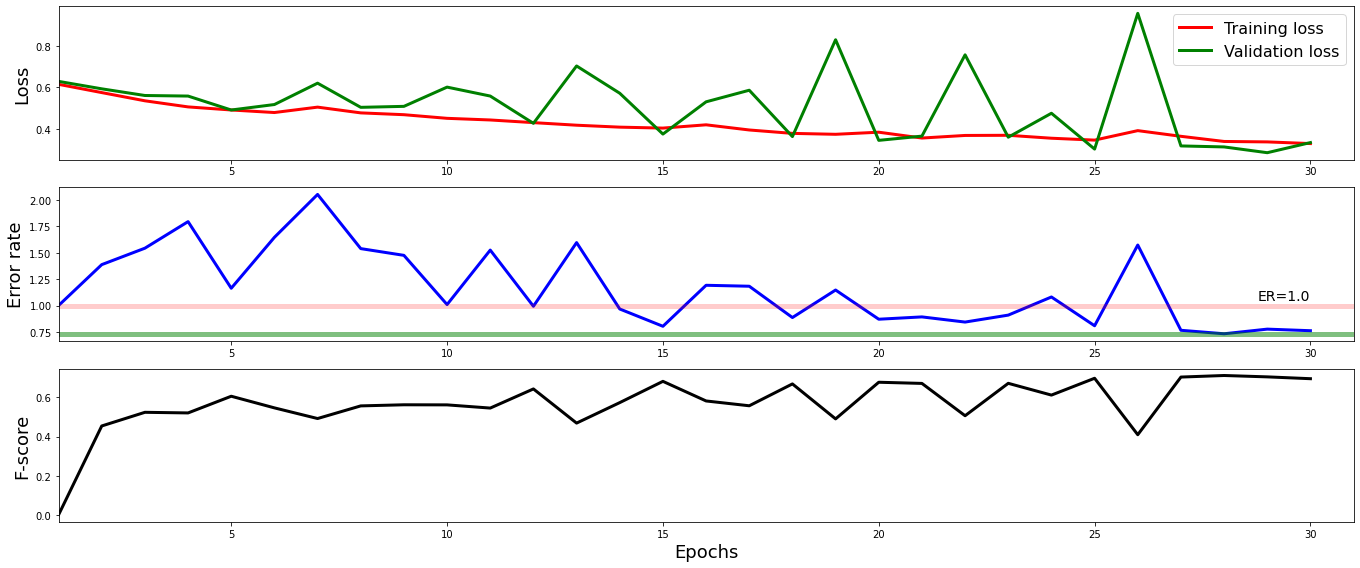

In [38]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))

plt.subplot(3,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
#plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(True)

plt.subplot(3,1,2)
plt.plot(epochs, hist['val_er'], color='blue', linewidth=3, label='Validation Error rate')
plt.axhline(y=1, color='red', linestyle='-', linewidth=5, alpha=0.2)
plt.ylabel('Error rate', fontsize=18)
er_min_index = numpy.argmin(hist['val_er'])
plt.axhline(hist['val_er'][er_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5) #'o', markersize=10, color='red')
plt.annotate('Minimum achieved ER value', xy=(len(hist['loss']),hist['val_er'][er_min_index]-0.15), fontsize=14, ha='right')
plt.annotate('ER=1.0', xy=(len(hist['loss']),1+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(True)

plt.subplot(3,1,3)
plt.plot(epochs, hist['val_f1'], color='black', linewidth=3, label='F-score')
plt.ylabel('F-score', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
plt.tight_layout()
plt.show()

# Testing stage

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight/model_seds_direct_script_upto_10_epochs_new.h5') # Load model

# Feature extractor and data sequencer are initialized here also to be able to run only testing stage.
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04,  # 40 ms 
    hop_length_seconds=0.02,  # 20 ms
    fs=44100
)

sequence_length = 450                              # 10s/0.02s=250 frames
data_sequencer = dcase_util.data.Sequencer(
    sequence_length=sequence_length
) 

current_fold = 1

## Going through all test material

In [ ]:
# temp = np.ones((2,3))
# temp[1][2] = 5
# print(temp)

In [ ]:
# temp = temp.reshape(1,2,3)

In [ ]:
# print(temp)

In [ ]:
# def binarization(self, probabilities, binarization_type='global_threshold', threshold=0.5, time_axis=1):
#         """Binarization
#         Parameters
#         ----------
#         probabilities : numpy.ndarray
#             Probabilities to be binarized
#         binarization_type : str ('global_threshold', 'class_threshold', 'frame_max')
#         threshold : float
#             Binarization threshold, value of the threshold are replaced with 1 and under with 0.
#             Default value 0.5
#         time_axis : int
#             Axis index for the frames
#             Default value 1
#         Raises
#         ------
#         AssertionError:
#             Unknown binarization_type
#         Returns
#         -------
#         numpy.ndarray
#             Binarized data
#         """

#         if binarization_type not in ['global_threshold', 'class_threshold', 'frame_max']:
#             message = '{name}: Unknown frame_binarization type [{type}].'.format(
#                 name=self.__class__.__name__,
#                 type=binarization_type
#             )

#             self.logger.exception(message)
#             raise AssertionError(message)

#         # Get data_axis
#         if time_axis == 0:
#             data_axis = 1
#         else:
#             data_axis = 0

#         if binarization_type == 'global_threshold':
#             return numpy.array(probabilities >= threshold, dtype=int)

#         elif binarization_type == 'class_threshold' and isinstance(threshold, list):
#             data = []
#             for class_id, class_threshold in enumerate(threshold):
#                 if data_axis == 0:
#                     data.append(numpy.array(probabilities[class_id, :] >= class_threshold, dtype=int))

#                 elif data_axis == 1:
#                     data.append(numpy.array(probabilities[:, class_id] >= class_threshold, dtype=int))

#             if data_axis == 0:
#                 return numpy.vstack(data)

#             elif data_axis == 1:
#                 return numpy.vstack(data).T

#         elif binarization_type == 'frame_max':
#             if data_axis == 0:
#                 return numpy.array((probabilities / numpy.max(probabilities, axis=0)) == 1, dtype=int)

#             elif data_axis == 1:
#                 return numpy.array((probabilities.T / numpy.max(probabilities, axis=1)).T == 1, dtype=int)

In [ ]:
# print(X_train[0,:,:])

In [ ]:
# def find_contiguous_regions(self, activity_array):
#         """Find contiguous regions from bool valued numpy.array.
#         Transforms boolean values for each frame into pairs of onsets and offsets.
#         Parameters
#         ----------
#         activity_array : numpy.array [shape=(t)]
#             Event activity array, bool values
#         Returns
#         -------
#         numpy.ndarray [shape=(2, number of found changes)]
#             Onset and offset indices pairs in matrix
#         """

#         # Find the changes in the activity_array
#         change_indices = numpy.logical_xor(activity_array[1:], activity_array[:-1]).nonzero()[0]

#         # Shift change_index with one, focus on frame after the change.
#         change_indices += 1

#         if activity_array[0]:
#             # If the first element of activity_array is True add 0 at the beginning
#             change_indices = numpy.r_[0, change_indices]

#         if activity_array[-1]:
#             # If the last element of activity_array is True, add the length of the array
#             change_indices = numpy.r_[change_indices, activity_array.size]

#         # Reshape the result into two columns
#         return change_indices.reshape((-1, 2))

In [ ]:
# print(X_train[0,:,:].reshape(1, X_train[0,:,:].shape[0], X_train[0,:,:].shape[1]).shape)

In [40]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_sed.csv'))

audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/validation'

for audio_filename in os.listdir(audio_folder_name):
    # Load features
    # features = get_feature_matrix(item.filename)
    # features_sequenced = data_sequencer.sequence(features).data
    # input_data = numpy.moveaxis(features_sequenced, 2, 0) # Rearrange axes => (sequence, feature vector, time)
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    #features = features[:,:500]
    input_data = features.reshape(1, features.shape[0], features.shape[1])


    # Get network output
    item_probabilities_seq = model.predict(x=input_data)        # Get per frame probabilities in sequences (3D matrix)
    item_probabilities = numpy.vstack(item_probabilities_seq)   # Merge sequences together (2D matrix)

    # Event activity
    event_activity = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=item_probabilities,
        binarization_type='global_threshold',
        threshold=0.5
    )
    current_estimated = dcase_util.containers.MetaDataContainer()
    for event_id, event_label in enumerate(['speech', 'music']):
        # Convert active frames into segments and translate frame indices into timestamps
        event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
            activity_array=event_activity[:, event_id]
        ) * 0.03194888178

        # Form event items
        for event in event_segments:
            current_estimated.append(
                {
                    'filename': audio_filename,
                    'onset': event[0],
                    'offset': event[1],
                    'event_label': event_label
                }
            )
            
        # Merge events together from same class which are within 100ms
        current_estimated = current_estimated.process_events(minimum_event_gap=0.5)
        # Remove events which are < 100ms 
        current_estimated = current_estimated.process_events(minimum_event_length=0.5)
        
    # Store result into results container
    res += current_estimated
    
# Save results container
res.save().show(mode='print')

MetaDataContainer :: Class
Filename                            : /content/data/results_sed.csv 
Items                               : 406 
Unique
  Files                             : 148 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Event statistics
  Event label             Count   Tot. Length   Avg. Length   
  --------------------   ------   -----------   -----------   
  music                     194        477.80          2.46   
  speech                    212        560.48          2.64   




# Evaluation

`sed_eval` toolbox is used to get Error rate and F-score for test set:

In [ ]:
print(validation_meta[0].filename)

S1


In [ ]:
res = dcase_util.containers.MetaDataContainer().load(filename=os.path.join(data_storage_path, 'results_sed.csv'))

## Preparing data for evaluation

Prepare reference data and estimated to have filenames in uniform format:

In [ ]:
reference_event_list = validation_meta
estimated_event_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_sed.csv')
).load()

# for item_id, item in enumerate(reference_event_list):
#   print(item.filename, item_id)
#   # reference_event_list[item_id][f'{filename}'] = os.path.split(item.filename)[-1]

for item_id, item in enumerate(estimated_event_list):
    estimated_event_list[item_id]['filename'] = item.filename.split('.')[0]    

In [ ]:
print(estimated_event_list)

MetaDataContainer :: Class
Filename                            : /content/data/results_sed.csv 
Items                               : 38 
Unique
  Files                             : 12 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S161                     3.07     8.98   -                 music             -                 -       
  S161                     3.07     3.64   -                 speech            -                 -       
  S161                     8.27    10.00   -                 speech            -                 -       
  S138                     0.38     0.96   -                 m

In [ ]:
print(reference_event_list)

MetaDataContainer :: Class
Items                               : 2160 
Unique
  Files                             : 1020 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S1                       0.00     5.00   -                 music             -                 -       
  S1                       5.00    10.00   -                 speech            -                 -       
  S2                       0.00     5.00   -                 music             -                 -       
  S2                       5.00    10.00   -                 speech            -                 -       
  S3                 

In [ ]:
# Initialize evaluator with list of event labels to be evaluated and segment length
evaluator = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=['speech', 'music'], 
    time_resolution=0.2                    # 1 second segments
)
# Loop file by file and accumulate intermediate statistics
for filename in reference_event_list.unique_files:
    evaluator.evaluate(
        reference_event_list=reference_event_list.filter(filename=filename),
        estimated_event_list=estimated_event_list.filter(filename=filename)
    ) 
metrics = evaluator.results_overall_metrics()

## Metric values

In [ ]:
log.table(
    column_headers=['Metric', 'Value'],
    cell_data=[
        [
          '<strong>F-score</strong>',
          'Precision',
          'Recall',
          '<strong>Error rate</strong>',
            'Substitutions',
            'Deletions',
            'Insertions'
        ],
        [
            metrics['f_measure']['f_measure']*100.0,
            metrics['f_measure']['precision']*100.0,
            metrics['f_measure']['recall']*100.0,
            metrics['error_rate']['error_rate'],
            metrics['error_rate']['substitution_rate'],
            metrics['error_rate']['deletion_rate'],
            metrics['error_rate']['insertion_rate'],
        ]
    ],
    row_separators=[3],
    scaling=130
)

Metric,Value
F-score,1.46
Precision,49.45
Recall,0.74
Error rate,1.00
Substitutions,0.00
Deletions,0.99
Insertions,0.00


## Class-wise metrics

In [ ]:
class_metrics = evaluator.results_class_wise_metrics()
Nref = []
Nsys = []
Fscore=[]
for event_label in list(class_metrics.keys()):
    Nref.append(class_metrics[event_label]['count']['Nref'])
    Nsys.append(class_metrics[event_label]['count']['Nsys'])
    Fscore.append(class_metrics[event_label]['f_measure']['f_measure']*100.0)
log.table(
    column_headers=['Event', 'Nref', 'Nsys', 'Fscore'],
    cell_data=[
        list(class_metrics.keys()),Nref,Nsys,Fscore
    ],
    column_types=['str25', 'int', 'int', 'float2'],
    column_separators=[0,2],
    scaling=130
)

Event,Nref,Nsys,Fscore
speech,15750,286,1.40
music,14250,237,1.10


Output directly from `sed_eval` evaluator:

In [ ]:
print(evaluator)    

Segment based metrics
  Evaluated length                  : 116.19 sec
  Evaluated files                   : 12 
  Segment length                    : 200.00 ms

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 41.85 %
    Precision                       : 32.61 %
    Recall                          : 58.40 %
  Error rate
    Error rate (ER)                 : 1.39 
    Substitution rate               : 0.24 
    Deletion rate                   : 0.18 
    Insertion rate                  : 0.97 
  Accuracy
    Sensitivity                     : 58.40 %
    Specificity                     : 40.96 %
    Balanced accuracy               : 49.68 %
    Accuracy                        : 46.69 %

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 41.59 %
    Precision                       : 33.30 %
    Recall                          : 59.44 %
  Error rate
    Error rate (ER)                 : 1.64 
    Deletion rate